Author : Sachin Kumar 

Roll no : 108118083 

Domain : Signal Processing and ML

Sub-domain : Machine Learning

## Twitter Sentiment Analysis



In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import re

In [3]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Load the dataset

In [0]:
directory = '/content/drive/My Drive/Inductions/Task 2'

train_pos = pd.read_csv(f'{directory}/train/pos.csv', encoding = "ISO-8859-1", header = None, names = ['tweets'])
train_neg = pd.read_csv(f'{directory}/train/neg.csv', encoding = "ISO-8859-1", header = None, names = ['tweets'])

test_pos = pd.read_csv(f'{directory}/test/test_pos.csv', error_bad_lines = False, header = None, names = ['tweets'])
test_neg = pd.read_csv(f'{directory}/test/test_neg.csv', error_bad_lines = False, header = None, names = ['tweets'])

In [5]:
print('Training data')
print('Number of Positive sentences', train_pos.shape)
print('Number of Negativ sentences', train_pos.shape)

print('-'*10)
print('Test data')
print('Number of Positive sentences', test_pos.shape)
print('Number of Negativ sentences', test_pos.shape)

Training data
Number of Positive sentences (800000, 1)
Number of Negativ sentences (800000, 1)
----------
Test data
Number of Positive sentences (182, 1)
Number of Negativ sentences (182, 1)


In [6]:
print('Some Positive tweets')
print(train_pos.head(5))

print('-'*50)
print('Some Negative tweets')
print(train_neg.head(5))

Some Positive tweets
                                              tweets
0       I LOVE @Health4UandPets u guys r the best!! 
1  im meeting up with one of my besties tonight! ...
2  @DaRealSunisaKim Thanks for the Twitter add, S...
3  Being sick can be really cheap when it hurts t...
4    @LovesBrooklyn2 he has that effect on everyone 
--------------------------------------------------
Some Negative tweets
                                              tweets
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1  is upset that he can't update his Facebook by ...
2  @Kenichan I dived many times for the ball. Man...
3    my whole body feels itchy and like its on fire 
4  @nationwideclass no, it's not behaving at all....


### Data Preprocessing

1. We need to remove stop words, links, usernames  and a lot of other trash from the tweets as they don't convey any sentiment.
    
    So let us write a function for that.

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#extract the most common words in english language
stop_words = stopwords.words("english")
#intialise lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()


def preprocess(text):
    
    # convert to lowercase
    text = text.lower()
    
    #remove punctuarion
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    #remove numbers
    text = re.sub(r'\d+', '', text)
    
    #remove usernames
    text = re.sub(r'@[^\s]+','', text)
    
    #remove links
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', '', text) 
    
    # heeeelllloooo => heelloo
    text = re.sub(r"(.)\1{4,}", r"\1"*4, text)
    
    #remove whitespaces from beginning and end
    text = text.strip()
    
    #tokenize
    word_tokens = word_tokenize(text)
    tokens = []
    
    #remove stop words
    for token in word_tokens:
        if token not in stop_words:
            tokens.append(token)
 
    #Lemmatization to reduce words to their base forms
    lemm_tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
        
    return " ".join(lemm_tokens)
    

Let us also add LABELS to the data. Then we will combine the positive and negative tweets and shuffle them.

In [0]:
POSITIVE = 0
NEGATIVE = 1

def add_labels(df, num_label):
    df = df.assign(label = pd.Series(np.ones(df.shape[0], dtype='int')*num_label))
    return df

#add labels to train and test dataset
train_pos = add_labels(train_pos, POSITIVE)
train_neg = add_labels(train_neg, NEGATIVE)

test_pos = add_labels(test_pos, POSITIVE)
test_neg = add_labels(test_neg, NEGATIVE)

In [0]:
def preprocess_and_combine(df_pos, df_neg):
    '''
    parameters:
        df_pos : dataframe containing positive tweets
        df_neg : dataframe containing negative tweets
    
    retruns:
        df_concat : dataframe containing preprocessed tweets
        with positive and negative examples shuffled
    '''
    
    #preprocessing the tweets column
    df_pos['tweets'] = df_pos['tweets'].apply(lambda x : preprocess(x))
    df_neg['tweets'] = df_neg['tweets'].apply(lambda x : preprocess(x))
    
    df_concat = pd.concat([df_pos, df_neg],)
    
    #shuffle by selecting random samples, and then resetting index
    df_concat = df_concat.sample(frac = 1).reset_index(drop = True)
    
    return df_concat   

Let us preprocess and combine the negative and positive sentiment tweets into a single dataframe, with shuffling.

In [0]:
train_data = preprocess_and_combine(train_pos, train_neg)
test_data = preprocess_and_combine(test_pos, test_neg)

In [0]:
#and store the labels of train and test data, in numpy arrays
train_labels = train_data['label'].values.reshape(1, -1)
test_labels = test_data['label'].values.reshape(1, -1)

Now, let us check a few tweets from the training set.

In [13]:
train_data.head(3)

,tweets,label
0,going footy soonhope dont freeze,0
1,jsykk thanks lot bro shes week old tomorrow cr...,0
2,goingg see jb sophiee stephhh back lateerr,0


Now that is much cleaner text.

### Word Embedding Matrix using Word2Vec algorithm

***Word Embeddings*** are vector representations that capture the context of the underlying words in relation to other words in the sentence. This transformation results in words having similar meaning being clustered closer together in the hyperplane and distinct words positioned further away in the hyperplane.

And ***Word2Vec***  is a 2 layer neural network, whose input is a text corpus and it's output is a set of vectors, which form the ***Word Embedding matrix***.

We can use ***pre-trained Word Embeddings*** as written in this keras [blog](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html), which is a better option when our training data is relatively small.

But Since we have a large amount of data with us, ***We will train our own Word Embeddings***, specific to our data.

In [0]:
from gensim.models.word2vec import Word2Vec

In [0]:
#We will create a list of words present in our text corpus
Bigger_list = []
for i in train_data['tweets']:
    li = list(i.split(" "))
    Bigger_list.append(li)

In [16]:
#hyperparams
W2V_SIZE = 100    #Size of vector representing each word
W2V_WINDOW = 7    
W2V_EPOCH = 32    
W2V_MIN_COUNT = 10  #Minimum number of times, the word should appear in text corpus
                    #for it to be included in vocabulary
                    #keeping 10, helps to avoid usernames present in tweets

#Let's train our word2Vec model
w2v_model = Word2Vec(Bigger_list, size = W2V_SIZE, window = W2V_WINDOW, min_count = W2V_MIN_COUNT, workers = 8)
#save the model
w2v_model.save("model.w2v")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Now, Let's create a dictionary mapping each word in Vocabulary to an integer.

In [17]:
#let's check out the vocabulary
vocab = list(w2v_model.wv.vocab)
print('Length of Vocabulary :',len(vocab))

#and create the dictionary
word_index = {}
for i, word in enumerate(vocab, 1): 
    word_index[word] = i

Length of Vocabulary : 41207


Let us analyze that our Word2Vec model if it learned correct relation in between the words present in text corpus. We can do that by finding similar words to a given word.

In [18]:
#let's check similarity
test_word = "great"
print('Top 5 words similar to', test_word)
w2v_model.wv.most_similar(test_word, topn = 5)

Top 5 words similar to great


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('fantastic', 0.83449387550354),
 ('wonderful', 0.7843339443206787),
 ('awesome', 0.7513692378997803),
 ('fabulous', 0.7495031952857971),
 ('good', 0.7337971925735474)]

Now we will club all the vectors together and form a ***Word Embedding Matrix*** which will be passed into the Neural Network.

In [19]:
vocab_size = len(word_index)+1   #one extra row for "out of vocabulary words"
#initialising the matrix with zeros
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))

for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]  #adding vector to the matrix

print('Shape of embedding matrix :', embedding_matrix.shape)

Shape of embedding matrix : (41208, 100)


#### Preparing the input to the Nerual Network.

We will transform the tweets to their integer form using the word_index dictionary. And, since not all the tweets are of same length, we will pad the shorter tweets with zeros.

In [20]:
def text_to_int(df, word_index, max_len):
    '''
        df : dataframe containing column "tweets"
        word_index : Dictionary contiaing mapping from words to int
        max_len : maximum length of each tweet
    '''
    X = np.zeros((df.shape[0], max_len))  #initialising the nd-array
    
    for i, tweet in enumerate(df.tweets):
        words = list(tweet.split(" "))
        j = 0
        for word in reversed(words):
            if word in word_index.keys():   #if present in our vocab
                X[i, max_len-1-j] = word_index[word]
                j += 1
    return X

#finding the longest tweet
max_len = 0
for list_ in Bigger_list:
    if len(list_)>max_len:
        max_len = len(list_)

print('Length of longest tweet is',max_len)

#converting train_data tweets to integer
X_train = text_to_int(train_data, word_index, max_len)

Length of longest tweet is 56


In [21]:
print(train_data.tweets[1], '\n mapped to \n', X_train[1])

jsykk thanks lot bro shes week old tomorrow crazy im obsessed new dad throwing pic every chance get 
 mapped to 
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21.]


Ok! So each of our training data tweets are mapped to integers and padded with zeros. Now they are ready to be fed into the neural network.

### Training the Neural Network 

So, now we will train the Neural Network to understand the relation between words present in the sentence to it's sentiment.
Since the ***order*** in which the words are present in sentence matters in defining it's sentiment, we must use RNN layers. 
Hence, I have written an ***LSTM layer from Scratch*** for our Nerual Network.

Since the data size is very large 16 lakhs. It would be better if we choose a random subset of the dataset every epoch and trianed the model on that.
Thus ensuring that the model sees many different training examples and also less training time.

In [0]:
from neural_net import NeuralNetwork

#hyperprams
EPOCHS = 10
LEARNING_RATE = 0.05
LSTM_UNITS = 50   #number of neurons in each LSTM cell
T_x = max_len      #Timesteps in input data
BATCH_SIZE = 256
SUBSET = 200000   # 2 lakh tweets 

#Initailising the neural network
model = NeuralNetwork(embedding_matrix, LSTM_UNITS, W2V_SIZE, T_x)

In [23]:
#Train the model
costs, avg_costs = model.train(X_train, train_labels, LEARNING_RATE, EPOCHS, SUBSET, batch_size = BATCH_SIZE)


#Or load the model
#directory = 'path/to/directory/saved_weights/'
#model.load_weights(directory)

Shape of training input (1600000, 56)
Epoch 1 finished. 	  Loss : 0.5861278220009918
Epoch 2 finished. 	  Loss : 0.5587407858458857
Epoch 3 finished. 	  Loss : 0.5449874365057856
Epoch 4 finished. 	  Loss : 0.5370430705008918
Epoch 5 finished. 	  Loss : 0.5309304288253223
Epoch 6 finished. 	  Loss : 0.5264710961239543
Epoch 7 finished. 	  Loss : 0.5227025170624636
Epoch 8 finished. 	  Loss : 0.5198600643334046
Epoch 9 finished. 	  Loss : 0.5175122104918393
Epoch 10 finished. 	  Loss : 0.5155533864338658


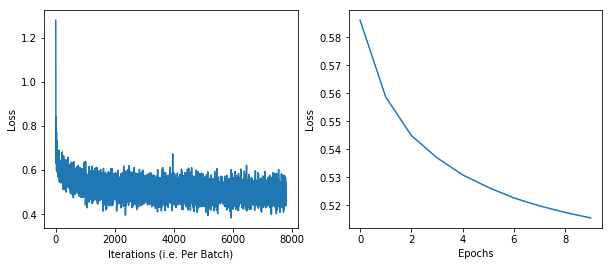

In [24]:
fig, ax = plt.subplots(nrows = 1, ncols=2)
fig.set_figwidth(10)
ax[0].plot(np.arange(1,len(costs)+1), costs)
ax[0].set_xlabel('Iterations (i.e. Per Batch)')
ax[0].set_ylabel('Loss')

ax[1].plot(np.arange(len(avg_costs)), avg_costs)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

In [26]:
#save the model weights
directory = '/content/drive/My Drive/Spider Task 3'
model.save_weights(directory)

All files saved successfully


### Testing the model

#### Preparing the test set input

We had performed Text Cleaning of the test data above. We also combined the positive and negative tweets after labeling them. Now we will transform the test set data from text to int using the vocabulary learned from the training data.

In [27]:
#converting train_data tweets to integer
X_test = text_to_int(test_data, word_index, max_len)
print('Shape of X_test',X_test.shape)

#Let's check one of the tweets
print('\n', test_data.tweets[0], '\n mapped to')
print(np.array(X_test[0], dtype='int')) 

Shape of X_test (359, 56)

 im moving east palo alto 
 mapped to
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0    13    94  2045 36602 20894]


In [28]:
# Predictions from the model
y_pred = model.predict(X_test)
print(y_pred.shape)

(1, 359)


#### Plotting the Confusion Matrix

In ***Binary Classification*** problems, ***Precision, Recall and F1 Score*** of the model are ***Important metrics*** to decide how good our model is.  
And the Cofusion Matrix, gives a good picture of that. Here is a link about [confusion matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62)

In [0]:
def get_metrics(y_true, y_pred):
    
    y_true, y_pred = y_true.ravel(), y_pred.ravel()  #unrolling for easy handling
    total = y_true.shape[0]
    
    true_positive, true_negative, false_positive, false_negative = 0,0,0,0
    for i in range(total):
        if y_true[i] == 1 and y_pred[i] == 1:
            true_positive += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            false_positive += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            false_negative += 1
        else:
            true_negative += 1
            
    precision = true_positive/(true_positive + false_positive)
    recall = true_positive/(true_positive + false_negative)
    f1_score = 2*precision*recall/(precision + recall)
    
    conf_matrix = np.array([[true_positive, false_positive],[false_negative, true_negative]])
    #calculating accuracy also
    accuracy = (true_positive + true_negative)/ total
    
    return precision, recall, f1_score, accuracy, conf_matrix

In [30]:
#Let's check how well our model performed

precision, recall, f1_score, accuracy, conf_matrix = get_metrics(test_labels, y_pred)

print('Accuracy  :', accuracy,'\n')
print('Precision :', precision)
print('Recall    :', recall)
print('F1 score  :', f1_score)

Accuracy  : 0.7994428969359332 

Precision : 0.8070175438596491
Recall    : 0.7796610169491526
F1 score  : 0.7931034482758621


[[138  33]
 [ 39 149]]


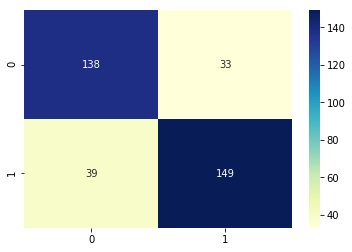

In [31]:
import seaborn as sns

print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", fmt='d')

#### Acknowledgements

- ***Coursera's Sequence Model*** course set the fundamentals for me.
- But LSTM was an optional part of their programming exercise in the course, and some of the formula's given by them were incorrect. So this [***Discussion Forums***](https://www.coursera.org/learn/nlp-sequence-models/discussions/weeks/1/threads/pRXJtJ_cEeiz4w5JxTItyg) thread really helped me out.
- Thanks ***Spider team*** for giving me a chance to ***code LSTM from scratch***.